# Imports

In [1]:
# progress bar
from tqdm import tqdm

# HTML parsing
from bs4 import BeautifulSoup

# file handling
import os
data_path = os.path.join('/zdata/user-data/noam/data/p2cs/merged_p2cs_data')
import glob

# data manipulation
import pandas as pd

# request handling
import requests

# regex
import re

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Linear algebra
import numpy as np

# Process management
import subprocess
import sys

# Phylogenetic analysis
from Bio import Entrez, Phylo
from ete3 import NCBITaxa
import dendropy
from collections import defaultdict
import pickle

# Time
import time

# Phylogenetic tree
from Bio import Phylo

/zdata/user-data/noam/.conda/envs/python310/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# Merge p2cs TSV files

In [2]:
# The base session page with the dropdown
export_page_url = "http://www.p2cs.org/index.php?section=export"

# Start a session to preserve cookies and PHPSESSID
session = requests.Session()

# Fetch the export page
response = session.get(export_page_url)
soup = BeautifulSoup(response.text, "html.parser")

# Extract all organism options from the <select name="exportDB"> dropdown
options = soup.find("select", {"name": "exportDB"}).find_all("option")
organism_db_ids = []
for opt in options:
    val = opt.get('value')
    if val:
        # Get only the first NavigableString before the <br> or other tags
        label = opt.contents[0].strip() if opt.contents else ''
        organism_db_ids.append((val, label))

db_id_to_name = {val: label for val, label in organism_db_ids}

print(f"Found {len(organism_db_ids)} organisms")

Found 3198 organisms


In [ ]:
# Folder with downloaded .txt files
folder = 'p2cs_exports_tsv'
file_paths = glob.glob(os.path.join(folder, '*.txt'))

dfs = []

for file_path in tqdm(file_paths, desc="Processing files", unit="file"):
    try:
        df = pd.read_csv(file_path, sep='\t', engine='python', on_bad_lines='skip', skiprows=1)

        if df.empty or len(df.columns) == 0:
            print(f"⚠️ Skipping empty or invalid file: {file_path}")
            continue

        # Extract organism names from filename (without .txt)
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        db_id = file_name.split('_')[0]

        df["file_name"] = file_name
        df["db_id"] = db_id
        df["organism"] = db_id_to_name.get(db_id, "Unknown")

        dfs.append(df)

    except Exception as e:
        print(f"❌ Failed to load {file_path}: {e}")

# All files share the same columns, so we can concatenate directly
combined_df = pd.concat(dfs, ignore_index=True)
print(f"✅ Combined {len(dfs)} files into one DataFrame with shape {combined_df.shape}")


Processing files: 100%|██████████| 3198/3198 [00:06<00:00, 485.19file/s]


✅ Combined 3198 files into one DataFrame with shape (148587, 12)


In [ ]:
def extract_last_number(gene):
    matches = re.findall(r'\d+', str(gene))
    return int(matches[-1]) if matches else None

combined_df['Gene_num'] = combined_df['Gene'].apply(extract_last_number)

In [104]:
combined_df['Start'] = combined_df['Start'].astype(int)
combined_df['Stop'] = combined_df['Stop'].astype(int)

# Compute reading frame for each gene
def compute_frame(row):
    if row['Strand'] == '+':
        return (row['Start'] - 1) % 3 + 1   
    elif row['Strand'] == '-':
        return -((row['Stop'] - 1) % 3 + 1)
    else:
        print(f"⚠️ Unknown strand for gene {row['Gene']}: {row['Strand']}")
        return None

combined_df['frame'] = combined_df.apply(compute_frame, axis=1)

## Save

In [ ]:
# combined_df.to_pickle("_p2cs_all_data.pkl")

# Merge Fasta Files

In [2]:
# The base session page with the dropdown
export_page_url = "http://www.p2cs.org/index.php?section=export"

# Start a session to preserve cookies and PHPSESSID
session = requests.Session()

# Fetch the export page
response = session.get(export_page_url)
soup = BeautifulSoup(response.text, "html.parser")

# Extract all organism options from the <select name="exportDB"> dropdown
options = soup.find("select", {"name": "exportDB"}).find_all("option")
organism_db_ids = []
for opt in options:
    val = opt.get('value')
    if val:
        # Get only the first NavigableString before the <br> or other tags
        label = opt.contents[0].strip() if opt.contents else ''
        organism_db_ids.append((val, label))

db_id_to_name = {val: label for val, label in organism_db_ids}

print(f"Found {len(organism_db_ids)} organisms")

Found 3198 organisms


In [20]:
# Folder with downloaded .txt files
folder = 'p2cs_exports_fasta'
aa_file_paths = glob.glob(os.path.join(folder, '*_aa.fasta'))
nt_file_paths = glob.glob(os.path.join(folder, '*_nt.fasta'))

dfs = []

for aa_file_path, nt_file_path in tqdm(zip(aa_file_paths, nt_file_paths), desc="Processing files", unit="file"):
    try:
        # Read amino acid FASTA
        # Read amino acid FASTA
        with open(aa_file_path, 'r') as f:
            aa_lines = f.read().splitlines()
        aa_entries = []
        entry_name = None
        seq_lines = []
        for line in aa_lines:
            if line.startswith('>'):
                if entry_name is not None:
                    aa_entries.append({'entry_name': entry_name, 'aa_sequence': ''.join(seq_lines)})
                entry_name = line[1:]
                seq_lines = []
            else:
                seq_lines.append(line)
        if entry_name is not None:
            aa_entries.append({'entry_name': entry_name, 'aa_sequence': ''.join(seq_lines)})
        aa_df = pd.DataFrame(aa_entries)

        # Read nucleotide FASTA
        with open(nt_file_path, 'r') as f:
            nt_lines = f.read().splitlines()
        nt_entries = []
        entry_name = None
        seq_lines = []
        for line in nt_lines:
            if line.startswith('>'):
                if entry_name is not None:
                    nt_entries.append({'entry_name': entry_name, 'nt_sequence': ''.join(seq_lines)})
                entry_name = line[1:]
                seq_lines = []
            else:
                seq_lines.append(line)
        if entry_name is not None:
            nt_entries.append({'entry_name': entry_name, 'nt_sequence': ''.join(seq_lines)})
        nt_df = pd.DataFrame(nt_entries)

        # Store aa_df and nt_df for merging later
        aa_df['file_name'] = os.path.splitext(os.path.basename(aa_file_path))[0]
        nt_df['file_name'] = os.path.splitext(os.path.basename(nt_file_path))[0]
        aa_df['db_id'] = aa_df['file_name'].str.split('_').str[0]
        nt_df['db_id'] = nt_df['file_name'].str.split('_').str[0]
        aa_df['organism'] = aa_df['db_id'].map(db_id_to_name).fillna("Unknown")
        nt_df['organism'] = nt_df['db_id'].map(db_id_to_name).fillna("Unknown")

        dfs.append((aa_df, nt_df))

    except Exception as e:
        print(f"❌ Failed to load {aa_file_path} or {nt_file_path}: {e}")

# Merge all aa_dfs and nt_dfs at the end
all_aa_df = pd.concat([aa for aa, nt in dfs], ignore_index=True)
all_nt_df = pd.concat([nt for aa, nt in dfs], ignore_index=True)

# Merge on entry_name, db_id, and organism to ensure correct alignment
sequences_df = pd.merge(
    all_aa_df, all_nt_df,
    on=['entry_name', 'db_id', 'organism'],
    how='outer',
    suffixes=('_aa', '_nt')
)

print(f"✅ Combined {len(dfs)} files into one DataFrame with shape {sequences_df.shape}")


Processing files: 3198file [00:15, 202.69file/s]


✅ Combined 3198 files into one DataFrame with shape (148793, 7)


In [21]:
def extract_gene_name(entry):
    parts = entry.split('_')
    for i, part in enumerate(parts, start=0):
        if (part == 'HK') or (part == 'RR') or (part == 'PP'):
            if i == 0:
                return '_'.join(parts[:2])
            else:
                return '_'.join(parts[:i])
    return entry  # If no HK/RR found, return full entry

sequences_df['gene_name'] = sequences_df['entry_name'].apply(extract_gene_name)
sequences_df = sequences_df[['gene_name', 'aa_sequence', 'nt_sequence', 'db_id', 'organism', 'entry_name', 'file_name_aa', 'file_name_nt']]

## Save

In [ ]:
# sequences_df.to_pickle("p2cs_all_sequences.pkl")

# Group by Operon, Filter Orphans, & Graph

## Load Data

In [3]:
all_df = pd.read_pickle(os.path.join(data_path, "_p2cs_all_data.pkl"))

In [4]:
# all_df = all_df.merge(
#     sequences_df[['gene_name', 'aa_sequence', 'nt_sequence', 'db_id']],
#     left_on=['Gene', 'db_id'],
#     right_on=['gene_name', 'db_id'],
#     how='left',
#     suffixes=('', '')
# )

# all_df = all_df.drop(columns=['gene_name'])

# all_df.to_pickle("_p2cs_all_data.pkl")

## Filter Data

### Group operons and filter By Integrenic Distance

In [ ]:
# Define the maximum allowed distance for genomic proximity
max_distance = 100  # 100

df_val = all_df.copy().reset_index(drop=True)

# Initialize group assignment
group_ids = []
current_group = 0

for i, row in df_val.iterrows():
    if i == 0:
        group_ids.append(current_group)
        continue
    prev_stop = df_val.loc[i - 1, 'Stop']
    curr_start = row['Start']
    prev_db_id = df_val.loc[i - 1, 'db_id']
    curr_db_id = row['db_id']
    prev_strand = df_val.loc[i - 1, 'Strand']
    curr_strand = row['Strand']
    if (
        (abs(curr_start - prev_stop) <= max_distance) and
        (curr_strand == prev_strand) and
        (curr_db_id == prev_db_id)
    ):
        # Same group
        group_ids.append(current_group)
    else:
        # New group
        current_group += 1
        group_ids.append(current_group)

df_val['proximity_group'] = group_ids

# Count the size of each proximity group
group_counts = df_val['proximity_group'].value_counts()

# Filter out groups with only one row
valid_groups = group_counts[group_counts > 1].index
orphan_groups = group_counts[group_counts == 1].index

df_val_filtered = df_val[df_val['proximity_group'].isin(valid_groups)].copy()
df_val_orphans = df_val[df_val['proximity_group'].isin(orphan_groups)].copy()

# df_val_filtered.to_pickle(os.path.join(data_path, "_p2cs_filtered_data.pkl"))
# df_val_orphans.to_pickle(os.path.join(data_path, "_p2cs_orphan_data.pkl"))


In [6]:
len(df_val_filtered), df_val_filtered['proximity_group'].nunique()

(87706, 42760)

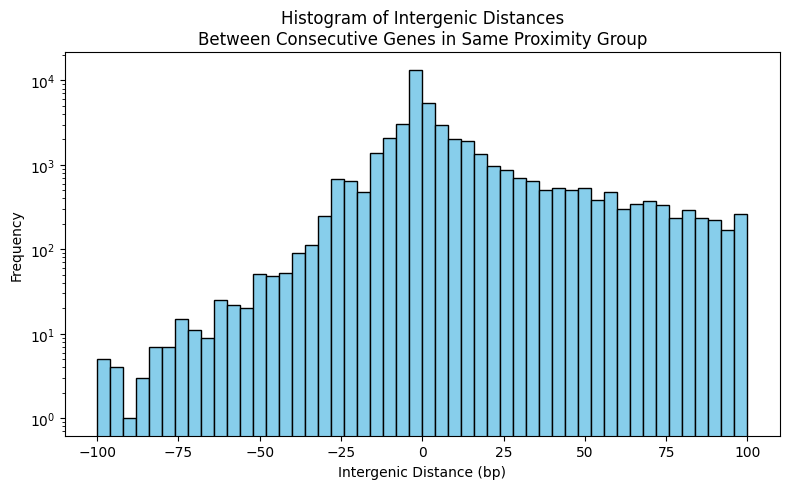

In [7]:
# Calculate intergenic distances between consecutive rows in the same proximity_group
df_val_filtered_sorted = df_val_filtered.sort_values(['proximity_group', 'Start'])
df_val_filtered_sorted['prev_stop'] = df_val_filtered_sorted.groupby('proximity_group')['Stop'].shift(1)
df_val_filtered_sorted['intergenic_distance'] = df_val_filtered_sorted['Start'] - df_val_filtered_sorted['prev_stop']

# Drop NaN values (first gene in each group)
intergenic_distances = df_val_filtered_sorted['intergenic_distance'].dropna()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(intergenic_distances, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Intergenic Distance (bp)')
plt.ylabel('Frequency')
plt.yscale('log')  # Use logarithmic scale for better visibility
plt.title('Histogram of Intergenic Distances\nBetween Consecutive Genes in Same Proximity Group')
plt.tight_layout()
plt.show()

### Add Organization Text Annotations

**Use organization annotations that were retrieved from P2CS with "2 fetch_tcs_organization.py"**

In [10]:
# first_quarter = pd.read_pickle("p2cs_filtered_data_0.pkl")
# second_quarter = pd.read_pickle("p2cs_filtered_data_1.pkl")
# third_quarter = pd.read_pickle("p2cs_filtered_data_2.pkl")
# fourth_quarter = pd.read_pickle("p2cs_filtered_data_3.pkl")

# # Combine all quarters into a single DataFrame
# quarters = [first_quarter, second_quarter, third_quarter, fourth_quarter]
# filtered_df = pd.concat(quarters, ignore_index=True)
# filtered_df.loc[filtered_df['tcs_organization'] == '', 'tcs_organization'] = 'Missing'

# --------------------------

# tcs_org_to_group_size = {"Orphan": 1, "": 1, np.nan: 1, "Pair": 2, "Triad": 3, "Tetrad": 4, "Pentad": 5, "Hexad": 6, "Heptad": 7, "Octad": 8, "Decad": 10}

# # Map group size from tcs_organization
# filtered_df['tcs_organization_int'] = filtered_df['tcs_organization'].map(tcs_org_to_group_size)

# # Calculate actual group size for each proximity_group
# group_sizes = filtered_df.groupby('proximity_group')['proximity_group'].transform('count')
# filtered_df['proximity_group_size'] = group_sizes

# --------------------------

# filtered_df = filtered_df.merge(
#     sequences_df[['gene_name', 'aa_sequence', 'nt_sequence', 'db_id']],
#     left_on=['Gene', 'db_id'],
#     right_on=['gene_name', 'db_id'],
#     how='left',
#     suffixes=('', '')
# )

# filtered_df = filtered_df.drop(columns=['gene_name'])
# filtered_df.to_pickle("_p2cs_filtered_data.pkl")

# --------------------------

filtered_df = pd.read_pickle(os.path.join(data_path, "_p2cs_filtered_data.pkl"))

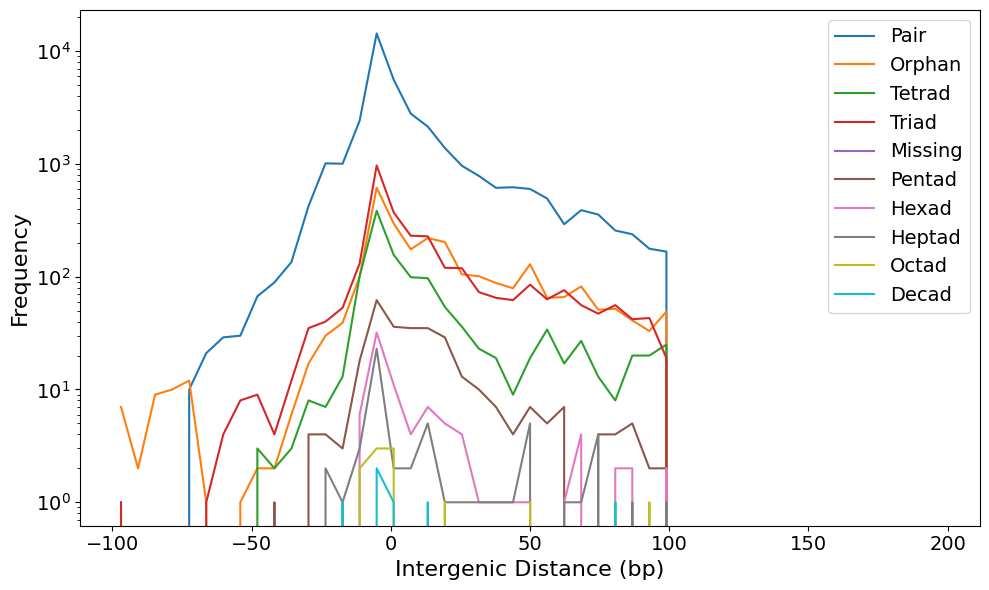

In [58]:
plt.figure(figsize=(10, 6))

# Get all unique tcs_organization values (excluding NaN/empty)
orgs = [org for org in filtered_df['tcs_organization'].unique() if isinstance(org, str) and org.strip()]

bins = np.linspace(-100, 200, 50)  # Adjust range as needed

for org in orgs:
    group = filtered_df[filtered_df['tcs_organization'] == org]
    group_sorted = group.sort_values(['db_id', 'proximity_group', 'Start'])
    group_sorted['prev_stop'] = group_sorted.groupby(['db_id', 'proximity_group'])['Stop'].shift(1)
    group_sorted['intergenic_distance'] = group_sorted['Start'] - group_sorted['prev_stop']
    distances = group_sorted['intergenic_distance'].dropna()
    counts, bin_edges = np.histogram(distances, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, label=org)

plt.xlabel('Intergenic Distance (bp)', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Frequency', fontsize=16)
plt.yticks(fontsize=14)
plt.yscale('log')  # Use logarithmic scale for better visibility
# plt.title('Frequency Polygons of Intergenic Distances by TCS Organization')
plt.legend(fontsize=14)
plt.tight_layout()

# plt.savefig("p2cs_intergenic_distances_by_tcs_organization.png", dpi=300)

plt.show()

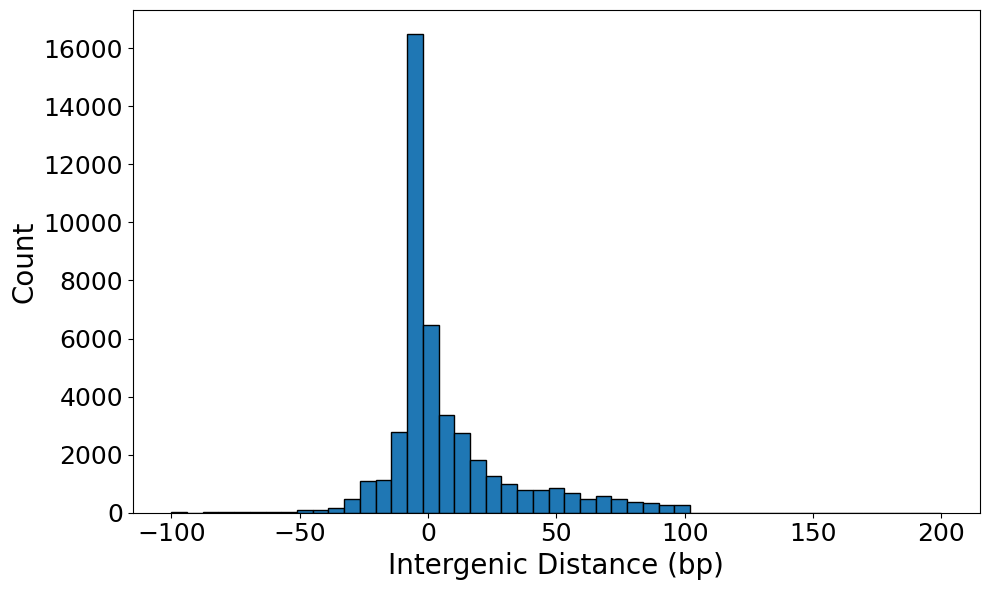

In [13]:
plt.figure(figsize=(10, 6))

# Compute intergenic distances for all records (regardless of tcs_organization)
filtered_sorted = filtered_df.sort_values(['db_id', 'proximity_group', 'Start'])
filtered_sorted['prev_stop'] = filtered_sorted.groupby(['db_id', 'proximity_group'])['Stop'].shift(1)
filtered_sorted['intergenic_distance'] = filtered_sorted['Start'] - filtered_sorted['prev_stop']

# Drop NA values (first in each group won't have a neighbor)
all_distances = filtered_sorted['intergenic_distance'].dropna()

bins = np.linspace(-100, 200, 50)  # Adjust as needed

counts, bin_edges, patches = plt.hist(
    all_distances, bins=bins, edgecolor='black'
)

plt.xlabel('Intergenic Distance (bp)', fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Count', fontsize=20)
plt.yticks(fontsize=18)
plt.tight_layout()

plt.savefig("histogram_p2cs_intergenic_distances.png", dpi=300)

plt.show()

In [62]:
len(filtered_df), filtered_df['proximity_group'].nunique()

(87704, 42760)

### Filter Out Remaining Orphans

In [37]:
filtered_df = pd.read_pickle(os.path.join(data_path, "_p2cs_filtered_data.pkl"))
orphan_df = pd.read_pickle(os.path.join(data_path, "_p2cs_orphan_data.pkl"))
len(filtered_df), len(orphan_df)

(87704, 60804)

In [46]:
# First, filter out orphans
non_orphan_df = filtered_df.loc[filtered_df['tcs_organization'] != 'Orphan'].copy()
# Recalculate proximity_group_size based on the filtered dataframe
non_orphan_df.loc[:, 'proximity_group_size'] = non_orphan_df.groupby('proximity_group')['proximity_group'].transform('count')
# Then filter out proximity groups of size 1
groups_df = non_orphan_df.loc[non_orphan_df['proximity_group_size'] > 1].copy()

# add filtered out rows to existing orphan_df
# Identify new orphans (not already in orphan_df), then append them as new rows
new_orphans = filtered_df.loc[
    (filtered_df['tcs_organization'] == 'Orphan') | (filtered_df['proximity_group_size'] <= 1)
].copy()
# Remove any that are already in orphan_df (using index or unique gene id)
if not orphan_df.empty:
    # Assuming 'Gene' is unique for orphans
    new_orphans = new_orphans[~new_orphans['Gene'].isin(orphan_df['Gene'])]
orphan_df = pd.concat([orphan_df, new_orphans], ignore_index=True)
# filter out rows with organization != 'Orphan' which are not NaN
orphan_df = orphan_df[(orphan_df['tcs_organization'] == 'Orphan') | (orphan_df['tcs_organization'].isna())]

orphan_df.to_pickle(os.path.join(data_path, "_p2cs_orphan_data.pkl"))

len(orphan_df)

66194

In [ ]:
# drop duplicate gene and update proximity groups
groups_df.drop([60369], inplace=True)

groups_df.loc[60385, 'proximity_group'] = 70659
groups_df.loc[groups_df['proximity_group'].isin([70659]), 'proximity_group_size']
groups_df.reset_index(inplace=True, drop=True)
groups_df['Gene'].is_unique

### Add cognate count

In [36]:
rr_proximity_groups = groups_df[groups_df['class'] == 'RR']
hk_proximity_groups = groups_df[groups_df['class'] == 'HK']
pp_proximity_groups = groups_df[groups_df['class'] == 'PP']

rr_proximity_group_sizes = rr_proximity_groups['proximity_group'].value_counts()
hk_proximity_group_sizes = hk_proximity_groups['proximity_group'].value_counts()
pp_proximity_group_sizes = pp_proximity_groups['proximity_group'].value_counts()

hk_num_cognates = hk_proximity_groups['proximity_group'].map(rr_proximity_group_sizes).fillna(0).astype(int)
rr_num_cognates = rr_proximity_groups['proximity_group'].map(hk_proximity_group_sizes).fillna(0).astype(int)
pp_num_cognates = (
    pp_proximity_groups['proximity_group'].map(rr_proximity_group_sizes).fillna(0).astype(int) +
    pp_proximity_groups['proximity_group'].map(hk_proximity_group_sizes).fillna(0).astype(int)
)

groups_df.loc[groups_df['class'] == 'HK', 'num_cognates'] = hk_num_cognates
groups_df.loc[groups_df['class'] == 'RR', 'num_cognates'] = rr_num_cognates
groups_df.loc[groups_df['class'] == 'PP', 'num_cognates'] = pp_num_cognates

# move num_cognates from last column to third to last column
columns = groups_df.columns.tolist()
groups_df = groups_df[columns[:-3] + [columns[-1]] + [columns[-3]] + [columns[-2]]]

## Save

In [40]:
# groups_df.to_pickle("/zdata/user-data/noam/data/p2cs/p2cs_filtered_groups.pkl")
groups_df = pd.read_pickle("/zdata/user-data/noam/data/p2cs/p2cs_filtered_groups.pkl")

In [41]:
groups_df['class'].value_counts()

class
RR    41189
HK    40989
PP      134
Name: count, dtype: int64

In [42]:
groups_df.head()

,Gene,Start,Stop,Strand,Original description,class,type,P2CS description,tm,file_name,...,organism,Gene_num,frame,proximity_group,tcs_organization,tcs_organization_int,proximity_group_size,num_cognates,aa_sequence,nt_sequence
0,Asuc_0781,841792,842496,+,two component transcriptional regulator,RR,OmpR,"Response regulator, OmpR family contains 1 Res...",0,ActsuDB_Actinobacillus_succinogenes_130Z,...,Actinobacillus succinogenes 130Z,781,1,2,Pair,2.0,2,1.0,MTKILLVDDDIELTDLLGELLSLEGFDVVTAQNGLEALEKLDDGIC...,ATGACGAAAATTTTATTAGTCGATGACGATATCGAGTTAACTGATC...
1,Asuc_0782,842506,843927,+,two-component sensor protein,HK,Classic,"Histidine kinase, Classic contains 1 HAMP,1 Hi...",3,ActsuDB_Actinobacillus_succinogenes_130Z,...,Actinobacillus succinogenes 130Z,782,1,2,Pair,2.0,2,1.0,LFPFLQRINRLPVQLLASFWLVIFTTLSITFVLLHFLDSHRPEKLE...,TTGTTTCCCTTTTTGCAACGCATTAACCGCCTTCCTGTTCAGCTGC...
2,Asuc_1363,1517270,1517950,+,two component transcriptional regulator,RR,OmpR,"Response regulator, OmpR family contains 1 Res...",0,ActsuDB_Actinobacillus_succinogenes_130Z,...,Actinobacillus succinogenes 130Z,1363,2,5,Pair,2.0,2,1.0,MRVLLIEDDPLIGNGLNIGLTKSGFSVDWFTDGKTGLEAVKSAPYD...,ATGAGAGTTTTATTAATCGAAGACGATCCGTTAATCGGTAACGGTT...
3,Asuc_1364,1517925,1519298,+,hypothetical protein,HK,Classic,"Histidine kinase, Classic contains 1 2CSK_N,1 ...",2,ActsuDB_Actinobacillus_succinogenes_130Z,...,Actinobacillus succinogenes 130Z,1364,3,5,Pair,2.0,2,1.0,MMKLLKRRSLRFRLIVILSLAALVIWSMATAIAWFQAKNEVNKMFD...,ATGATGAAACTCCTGAAACGACGTAGTTTGCGTTTTCGTTTGATTG...
4,Asuc_1720,1888650,1890632,+,hypothetical protein,HK,Classic,"Histidine kinase, Classic contains 1 HisKA,1 H...",3,ActsuDB_Actinobacillus_succinogenes_130Z,...,Actinobacillus succinogenes 130Z,1720,3,6,Pair,2.0,2,1.0,MRKWINSLNISRGLQLSFWLSALLCLFVGGLGLLTWQQQRAEINIA...,ATGAGAAAATGGATTAACAGCTTAAATATCAGCCGTGGGTTACAGC...


In [43]:
groups_df['length_aa'] = groups_df['aa_sequence'].apply(len)

In [44]:
groups_df['length_aa'].describe()

count    82312.000000
mean       398.872923
std        213.506013
min         33.000000
25%        229.000000
50%        377.000000
75%        481.000000
max       3470.000000
Name: length_aa, dtype: float64

In [ ]:
p2cs_filtered_groups = pd.read_pickle(os.path.join(data_path, "p2cs_filtered_groups.pkl"))

In [3]:
p2cs_filtered_groups.head()

,Gene,Start,Stop,Strand,Original description,class,type,P2CS description,tm,file_name,db_id,organism,Gene_num,frame,proximity_group,tcs_organization,tcs_organization_int,proximity_group_size,aa_sequence,nt_sequence
0,Asuc_0781,841792,842496,+,two component transcriptional regulator,RR,OmpR,"Response regulator, OmpR family contains 1 Res...",0,ActsuDB_Actinobacillus_succinogenes_130Z,ActsuDB,Actinobacillus succinogenes 130Z,781,1,2,Pair,2.0,2,MTKILLVDDDIELTDLLGELLSLEGFDVVTAQNGLEALEKLDDGIC...,ATGACGAAAATTTTATTAGTCGATGACGATATCGAGTTAACTGATC...
1,Asuc_0782,842506,843927,+,two-component sensor protein,HK,Classic,"Histidine kinase, Classic contains 1 HAMP,1 Hi...",3,ActsuDB_Actinobacillus_succinogenes_130Z,ActsuDB,Actinobacillus succinogenes 130Z,782,1,2,Pair,2.0,2,LFPFLQRINRLPVQLLASFWLVIFTTLSITFVLLHFLDSHRPEKLE...,TTGTTTCCCTTTTTGCAACGCATTAACCGCCTTCCTGTTCAGCTGC...
2,Asuc_1363,1517270,1517950,+,two component transcriptional regulator,RR,OmpR,"Response regulator, OmpR family contains 1 Res...",0,ActsuDB_Actinobacillus_succinogenes_130Z,ActsuDB,Actinobacillus succinogenes 130Z,1363,2,5,Pair,2.0,2,MRVLLIEDDPLIGNGLNIGLTKSGFSVDWFTDGKTGLEAVKSAPYD...,ATGAGAGTTTTATTAATCGAAGACGATCCGTTAATCGGTAACGGTT...
3,Asuc_1364,1517925,1519298,+,hypothetical protein,HK,Classic,"Histidine kinase, Classic contains 1 2CSK_N,1 ...",2,ActsuDB_Actinobacillus_succinogenes_130Z,ActsuDB,Actinobacillus succinogenes 130Z,1364,3,5,Pair,2.0,2,MMKLLKRRSLRFRLIVILSLAALVIWSMATAIAWFQAKNEVNKMFD...,ATGATGAAACTCCTGAAACGACGTAGTTTGCGTTTTCGTTTGATTG...
4,Asuc_1720,1888650,1890632,+,hypothetical protein,HK,Classic,"Histidine kinase, Classic contains 1 HisKA,1 H...",3,ActsuDB_Actinobacillus_succinogenes_130Z,ActsuDB,Actinobacillus succinogenes 130Z,1720,3,6,Pair,2.0,2,MRKWINSLNISRGLQLSFWLSALLCLFVGGLGLLTWQQQRAEINIA...,ATGAGAAAATGGATTAACAGCTTAAATATCAGCCGTGGGTTACAGC...


In [4]:
# Check unique organisms and their database IDs
print("Unique organisms:")
print(f"Total unique organisms: {p2cs_filtered_groups['organism'].nunique()}")
print("\nUnique organism names:")
unique_organisms = p2cs_filtered_groups[['db_id', 'organism']].drop_duplicates()
print(unique_organisms.head(10))
print(f"\nTotal unique db_id values: {p2cs_filtered_groups['db_id'].nunique()}")

Unique organisms:
Total unique organisms: 2649

Unique organism names:
        db_id                                       organism
0     ActsuDB               Actinobacillus succinogenes 130Z
6     Bura4DB                  Burkholderia ambifaria MC40-6
44    Strl1DB                  Streptococcus lutetiensis 033
66    Burp9DB                Burkholderia pseudomallei 1710b
96    AmmdeDB                         Ammonifex degensii KC4
114  Vibc16DB                Vibrio campbellii ATCC BAA-1116
136   PseenDB                    Pseudomonas entomophila L48
214   Camj1DB      Campylobacter jejuni subsp. jejuni 81-176
224   Dins1DB  Dinoroseobacter shibae DFL 12 plasmid pDSHI01
226   Borp4DB                     Bordetella pertussis 18323

Total unique db_id values: 2855
